In [280]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torchvision as tv
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D

mnist_data = tv.datasets.MNIST(root=os.getcwd(),
                               download=True,
                               transform=tv.transforms.ToTensor())

kmnist_data = tv.datasets.KMNIST(root=os.getcwd(),
                                 download=True,
                                 transform=tv.transforms.ToTensor())

# Dataset at http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar
kanji_data = tv.datasets.DatasetFolder(
    root=os.getcwd() + '/kkanji2',
    loader=PIL.Image.open,
    extensions=('.png'),
    transform=tv.transforms.Compose([
        tv.transforms.Grayscale(num_output_channels=1),
        tv.transforms.ToTensor()]
    )
)

class VAE(nn.Module):
    def __init__(self, img_width, dim_z, device):
        super().__init__()
        
        self.c = 64 # No. output channels of the first convolution
        c = self.c
        fc_input_dim = self.c * 2 * (img_width // 4) ** 2
        
        # Encoder parameters
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1)
        self.fc1 = nn.Linear(fc_input_dim, dim_z)
        self.fc2 = nn.Linear(fc_input_dim, dim_z)
        
        # Decoder parameters
        self.fc3 = nn.Linear(dim_z, fc_input_dim)
        self.conv3 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
        
        # Define the prior distribution for p(z) as N(0,I)
        self.prior = D.Normal(torch.zeros(dim_z).to(device), torch.ones(dim_z).to(device))
        
        self.to(device)
    
    def encode(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.flatten(start_dim=1)
        mu = self.fc1(x)
        std = self.fc2(x)
        return D.Normal(mu, std)
    
    def decode(self, z):
        z = torch.relu(self.fc3(z))
        z = z.view(z.shape[0], self.c*2, img_width//4, img_width//4)
        z = torch.relu(self.conv3(z))
        logits = self.conv4(z)
        return logits
    
    def forward(self, x):
        q_z = self.encode(x)
        z = q_z.rsample()
        return self.decode(z), q_z
    
    def loss(self, target, output, q_z):
        divergence = D.kl_divergence(q_z, self.prior).sum(dim=1).mean()
        BCE = F.binary_cross_entropy_with_logits(output, target, reduction='sum')
        return BCE + divergence
    
    def sample(self, z=None, prior=None):
        with torch.no_grad():
            if prior is not None:
                z = prior.sample().unsqueeze(dim=0)
            elif z is None:
                z = self.prior.sample().unsqueeze(dim=0)
            return torch.sigmoid(self.decode(z))

# Make a grid from a batch of images.
# The batch must have shape [n_rows ** 2, 1, img_width, img_width]
def plot_grid(batch, img_width, n_rows, cmap="gray", fname=None):
    pics = batch.reshape([-1, img_width]).split(img_width)
    rows, i = [], 0
    while i < len(pics):
        row = torch.cat(pics[i:i+n_rows])
        rows.append(row)
        i += n_rows
    grid = torch.cat(rows, dim=1).to('cpu')
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(grid, cmap=cmap)
    if fname:
        plt.imsave(fname, grid, cmap=cmap)

In [5]:
dataset = kanji_data
epochs = 27
batch_size = 128
use_gpu = True
device = torch.device("cuda" if use_gpu else "cpu")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
#img_width = 28
img_width = 64
dim_z = 100 # code size
vae = VAE(img_width, dim_z, device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(epochs):
    n_batches, sum_loss = 0, 0
    for batch, _ in dataloader:
        optimizer.zero_grad()
        targets = batch.to(device)
        out, q_z = vae(targets)
        loss = vae.loss(targets, out, q_z)
        loss.backward()
        optimizer.step()
        
        n_batches += 1
        sum_loss += loss.detach().item()
    print('epoch {:3d}\tmean loss {:.0f}'.format(epoch+1, sum_loss / n_batches))

epoch   1	mean loss 104728
epoch   2	mean loss 80194
epoch   3	mean loss 77581
epoch   4	mean loss 75093
epoch   5	mean loss 74546
epoch   6	mean loss 74471
epoch   7	mean loss 72900
epoch   8	mean loss 71355
epoch   9	mean loss 70982
epoch  10	mean loss 70676
epoch  11	mean loss 70216
epoch  12	mean loss 70078
epoch  13	mean loss 70883
epoch  14	mean loss 69864
epoch  15	mean loss 70713
epoch  16	mean loss 70471
epoch  17	mean loss 69132
epoch  18	mean loss 68429
epoch  19	mean loss 68514
epoch  20	mean loss 69291
epoch  21	mean loss 68578
epoch  22	mean loss 68956
epoch  23	mean loss 68819
epoch  24	mean loss 68947
epoch  25	mean loss 69857
epoch  26	mean loss 68475
epoch  27	mean loss 67704


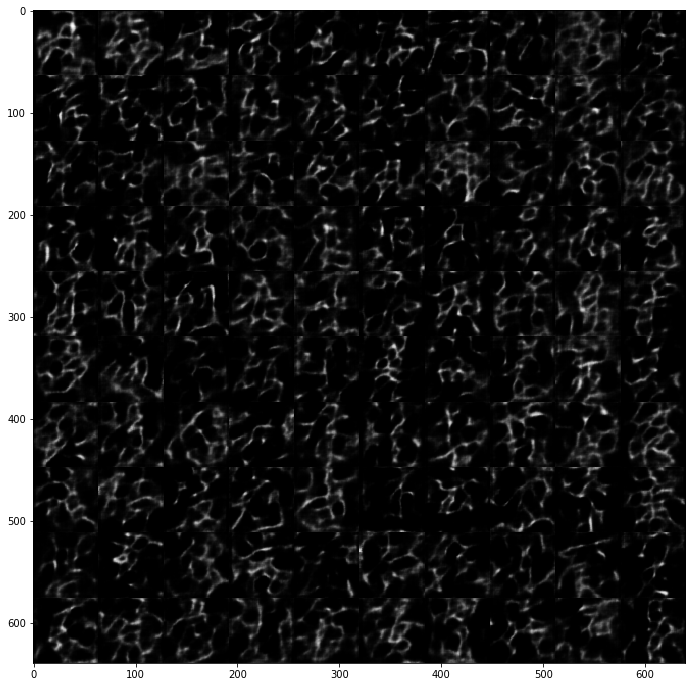

In [273]:
# Make a grid of images, sampling from the prior
n_rows = 10
batch = torch.cat([vae.sample() for _ in range(n_rows**2)])
plot_grid(batch, img_width, n_rows)

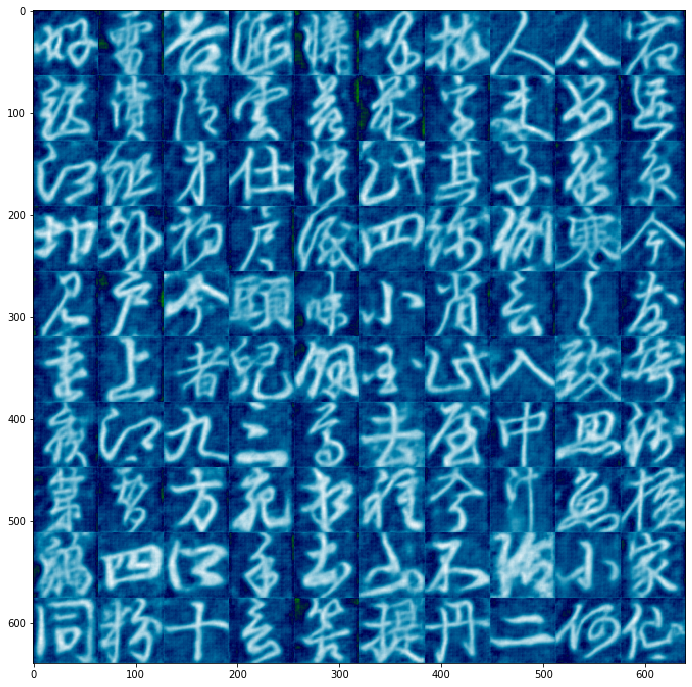

In [275]:
# Make a grid of reconstructed examples
n_rows = 10
for batch, _ in dataloader:
    batch = batch[:n_rows**2].to(device)
    break
with torch.no_grad():
    grid, _ = vae(batch)
plot_grid(grid, img_width, n_rows, cmap="ocean")

In [276]:
# Map points in the latent space to a grid
# This can only be done with a two dimensional latent space
if dim_z == 2:
    n_rows = 25
    z_scale = 5.5
    latents = torch.linspace(-z_scale, z_scale, n_rows)
    latent_batch = torch.FloatTensor(n_rows, n_rows, 2)
    for i in range(n_rows):
        for j in range(n_rows):
            latent_batch[i][j][0] = latents[i]
            latent_batch[i][j][1] = latents[j]
    latent_batch = latent_batch.view(-1, 2).to(device)
    out = vae.sample(z=latent_batch)
    plot_grid(out, img_width, n_rows)